In [1]:
# imports 
import gymnasium as gym
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm
from action_selection import NbEpsilonGreedy, NbSoftmax

In [83]:
from collections import namedtuple
MDPTransition = namedtuple(
    "MDPTransition",
    field_names=[
        "state",
        "action",
        "reward",
        "next_state",
        "terminated",
        "truncated",
        "info",
    ],
)
SMDPTransition = namedtuple(
    "SMDPTransition",
    field_names=[
        "state",
        "action",
        "time_taken",
        "reward",
        "next_state",
        "terminated",
        "truncated",
        "info",
    ],
)

In [84]:
passenger_locations = ["red","green","yellow","blue","in_taxi"]
destinations=["red","green","yellow","blue"]
positions = [(0,0),(0,4),(4,0),(4,3)]

def decode_state(state):
    destination = state % 4
    state //= 4
    passenger_location = state % 5
    state //= 5
    taxi_col = state % 5
    state //= 5
    taxi_row = state
    return taxi_row, taxi_col, passenger_location, destination

In [85]:
# implement Options

class Option:
    def __init__(self,name:str, env:gym.Env ,initiation:callable, termination:callable):
        '''Class for an Option
        initiation - callable(state)->bool
        termination - callable(state)->bool
        '''
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        self.name = name
        self.initiation = initiation
        self.termination = termination
        self.reset()

    def reset(self):
        self.q_table = np.zeros((self.n_states,self.n_actions))
    
    def __str__(self) -> str:
        return self.name
    

In [220]:
import matplotlib.pyplot as plt


def reward_plot(scores, message=""):
    plt.figure(figsize=(15,5))
    plt.plot(scores,linewidth=.5)
    plt.xlabel("episode")
    plt.ylabel("reward")
    plt.title("reward curve " + message)
    plt.show()

In [305]:
class OptionsAgent:
    def __init__(self, env:gym.Env, options:list[Option], action_selection, alpha=.1, gamma=.99):
        self.options = options
        # Option value table
        self.n_primitives = env.action_space.n
        self.n_actions  = self.n_primitives+len(options)
        self.n_states = env.observation_space.n

        self.q_omega_table = np.zeros((self.n_states,self.n_actions))
        self.action_selection = action_selection
        self.alpha = alpha
        self.gamma = gamma
    
    
    def learn(self, step_tuple:SMDPTransition):
        state, action, time_taken, reward, next_state, *_, info = step_tuple
        action_mask = info['option_mask']
        self.q_omega_table[state,action] \
            += self.alpha*(reward+self.gamma**time_taken*np.max(self.q_omega_table[next_state,action_mask]) - self.q_omega_table[state,action])
    
    def option_learn(self,step_tuple:MDPTransition):
        state, action, reward, next_state,*_,info = step_tuple

        option = self.executing_option
        
        opt_reward = (1-option.termination(state)) * reward 
        action_mask = info["action_mask"]
        option.q_table[state,action] \
            += self.alpha*(opt_reward+self.gamma*np.max(option.q_table[next_state,action_mask]) - option.q_table[state,action])    
            



    def execute_option(self,env:gym.Env, state, option:Option, info=None, step_callbacks = []):
        '''Executes the option from the current state and returns the rewards.
        Returns: (t, next_state, reward, terminated, truncated, info)
        '''
        done = False
        rewards = []
        t=0
        if step_callbacks is None:
            step_callbacks = []
        while not done:
            action = self.action_selection(option.q_table[state][info["action_mask"].astype(bool)])
            action = np.arange(self.n_primitives)[info["action_mask"].astype(bool)][action]

            next_state, reward, terminated, truncated, info = env.step(action)        
            step_tuple = MDPTransition(
                state, action, reward, next_state, terminated, truncated, info
            )
            for step_callback in step_callbacks:
                step_callback(step_tuple)

            rewards.append(reward)        
            state = next_state
            t+=1
            done = option.termination(state) | terminated | truncated
            if done: 
                break
        
        reward_bar = 0
        for reward in rewards[::-1]:
            reward_bar= reward_bar*self.gamma + reward
        
        return t, next_state, reward_bar, terminated, truncated, info

    def run_episode(self, env:gym.Env,option_step_callbacks=None, step_callbacks=None):
            if option_step_callbacks is None:
                option_step_callbacks = []
            time_step = 0
            state, info = env.reset()
            option_mask = lambda action_mask,state: np.array(
                    action_mask.tolist()
                    +[option.initiation(state) for option in self.options]
                    ,dtype=bool 
                )
            info["option_mask"] = option_mask(info["action_mask"],state)
            done= False
            while not done:
                
                action = self.action_selection(self.q_omega_table[state,info["option_mask"]])
                action = np.arange(self.n_actions)[info["option_mask"]][action]
                assert info["option_mask"][action] ==1, f"{info['option_mask']} - {action}"
                if action<self.n_primitives:
                    next_state, reward, terminated, truncated, info = env.step(action)
                    t = 1

                else:
                    self.executing_option = self.options[action - self.n_primitives]
                    t, next_state, reward,terminated, truncated, info= self.execute_option(
                        env,state,
                        self.executing_option,
                        info=info, step_callbacks=step_callbacks
                    )
                    self.executing_option = None
                info["option_mask"] = option_mask(info["action_mask"],next_state)
                time_step+=t
                step_tuple = SMDPTransition(
                    state, action, t, reward, next_state, terminated, truncated, info
                )
                # print(step_tuple)
                for option_step_callback in option_step_callbacks:
                    option_step_callback(step_tuple)

                state = next_state

                if terminated | truncated:
                    break            


    def train(self,env: gym.Env,n_episodes=10000,plot=False):
        all_rewards = []
        for i_episode in tqdm(range(1, n_episodes + 1)):
            rewards = 0
            def accumulate_reward(step_tuple):
                nonlocal rewards
                rewards+=step_tuple.reward
            self.run_episode(
                env, 
                option_step_callbacks=[self.learn,accumulate_reward],
                step_callbacks=[self.option_learn]
            )

            all_rewards.append(rewards)

        if plot:
            reward_plot(
                all_rewards, message=f"Env:{env.spec.name}, Agent:{self.__class__.__name__}"
            )
        return all_rewards

class IntraOptionAgent(OptionsAgent):
    def learn(self, step_tuple:SMDPTransition):
        state, action, time_taken, reward, next_state, *_, info = step_tuple
        action_mask = info['option_mask']
        self.q_omega_table[state,action] \
            += self.alpha*(reward+self.gamma**time_taken*np.max(self.q_omega_table[next_state,action_mask]) - self.q_omega_table[state,action])
        if action<self.n_primitives:
            for option in self.options:
                if np.arange(self.n_primitives)[option.q_table[state,action_mask[:self.n_primitives]].argmax()]==action:
                    optdone = option.termination(state)
                    opt_reward = (1-option.termination(state)) * reward 
                    U = (1-optdone)*option.q_table[state,action] + optdone*(np.max(option.q_table[next_state,action_mask[:self.n_primitives]]))
                    option.q_table[state,action] +=  self.alpha*( opt_reward+self.gamma*U - option.q_table[state,action] )

    def option_learn(self,step_tuple:MDPTransition):
        state, action, reward, next_state,*_,info = step_tuple
        option = self.executing_option
        action_mask = info["action_mask"]

        self.q_omega_table[state,action] \
            += self.alpha*(reward+self.gamma*np.max(self.q_omega_table[next_state,action_mask]) - self.q_omega_table[state,action])

        opt_reward = (1-option.termination(state)) * reward
        option.q_table[state,action] \
            += self.alpha*(opt_reward+self.gamma*np.max(option.q_table[next_state,action_mask]) - option.q_table[state,action])
        
        for other_option in self.options:
            if other_option != option and np.arange(self.n_primitives)[other_option.q_table[state,action_mask].argmax()]==action:
                optdone = other_option.termination(state)
                opt_reward = (1-other_option.termination(state)) * reward
                U = (1-optdone)*other_option.q_table[state,action] + optdone*(np.max(other_option.q_table[next_state,action_mask]))
                other_option.q_table[state,action] +=  self.alpha*( opt_reward+self.gamma*U - other_option.q_table[state,action] )
    

env = gym.make("Taxi-v3")

options = [
    Option(
        f"goto_{destination}",env,
        initiation = lambda state, position=position: decode_state(state)[:2]!=position, 
        termination = lambda state,position=position: decode_state(state)[:2]==position
    )
    for destination,position in zip(destinations,positions)
]
# action_selection = NbSoftmax(3)
gamma = .95
alpha = 1
# action_selection = NbEpsilonGreedy(.0001).choose_action
action_selection = np.argmax
option_agent = OptionsAgent(env, options, action_selection,gamma=gamma,alpha=alpha)
intra_option_agent = IntraOptionAgent(env, options, action_selection,gamma=gamma,alpha=alpha)

100%|██████████| 10000/10000 [00:14<00:00, 713.76it/s]


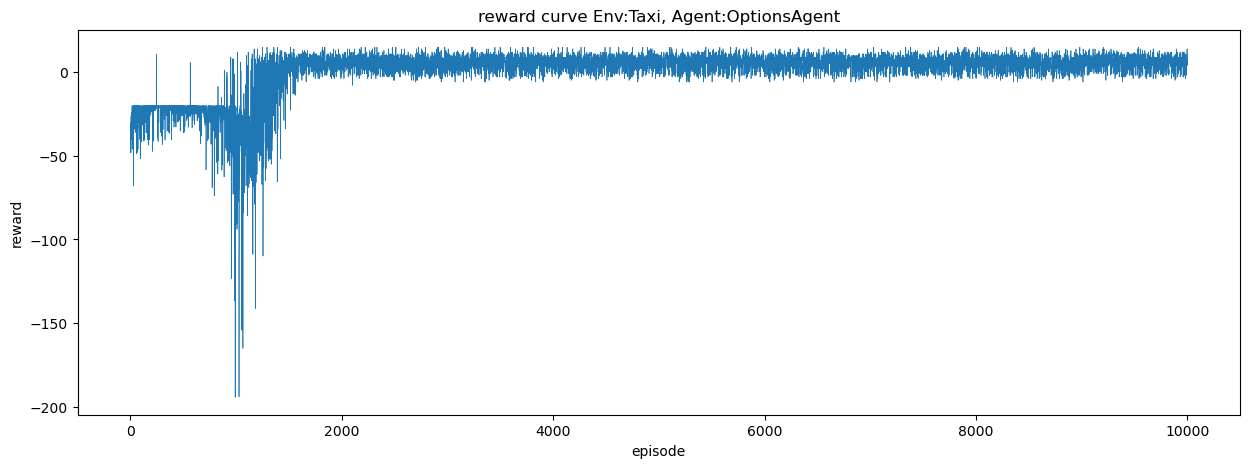

100%|██████████| 10000/10000 [00:17<00:00, 557.35it/s]


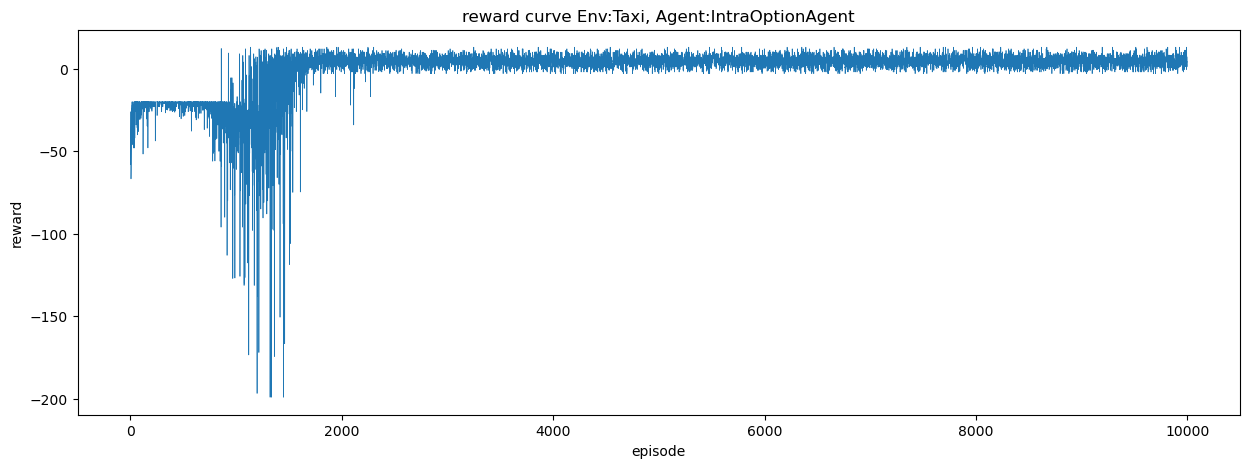

In [306]:
option_rewards = option_agent.train(env,10000,True)
intra_option_rewards = intra_option_agent.train(env,10000,True)

In [307]:
from joblib import Parallel, delayed


option_rewards  = Parallel(n_jobs=-1,backend="loky")(
    delayed(OptionsAgent(env, options, action_selection,gamma=gamma,alpha=alpha).train)(env,10000)
    for i in range(20)
)
intra_option_rewards  = Parallel(n_jobs=-1,backend="loky")(
    delayed(IntraOptionAgent(env, options, action_selection,gamma=gamma,alpha=alpha).train)(env,10000) 
    for i in range(20)
)

100%|██████████| 10000/10000 [00:36<00:00, 275.02it/s]


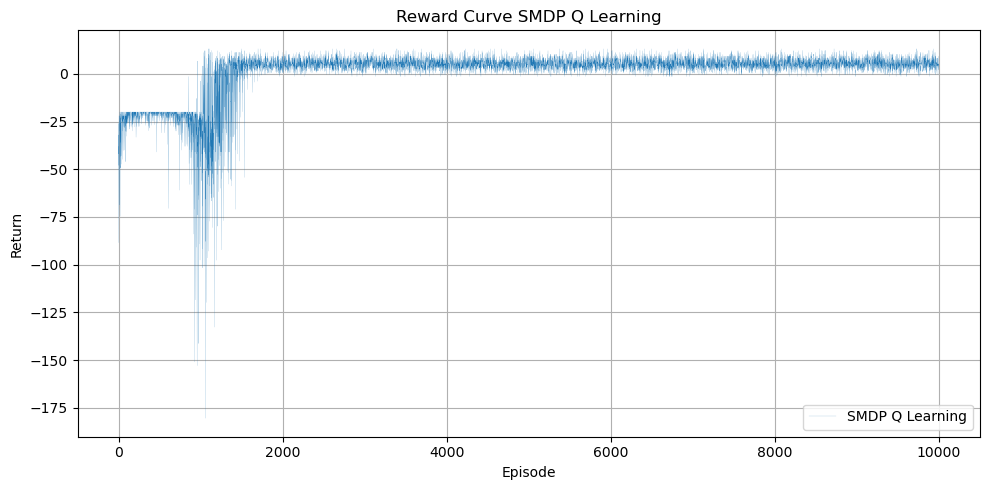

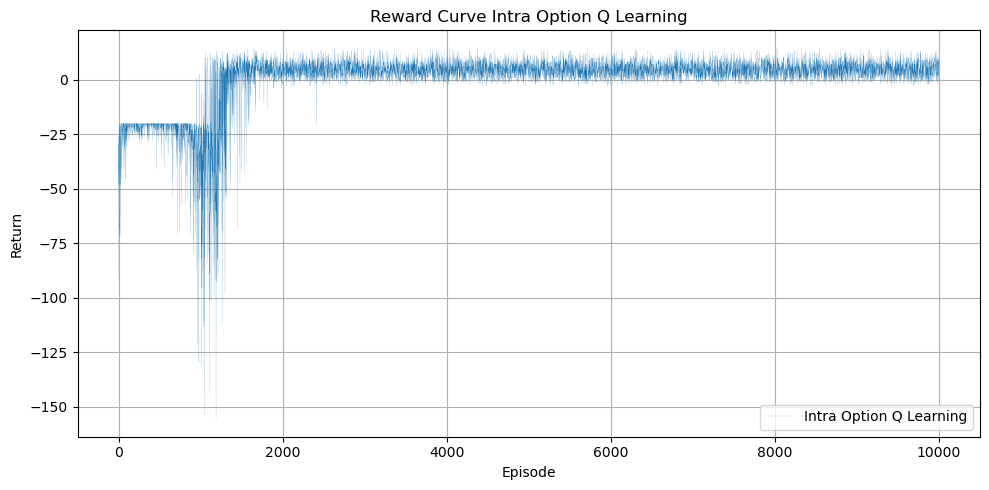

(5.366523499999996, 4.805842337499998)

In [308]:
import matplotlib.pyplot as plt

import numpy as np


def plot_reward_curve(rewards_list, labels, message = "", linewidth=.1):
    max_rewards = max(map(len,[rewards for reward_list in rewards_list for rewards in reward_list]))
    
    plt.figure(figsize=(10, 5))
    for i,rewards in enumerate(rewards_list):
        rewards = np.array(list(map(lambda x: np.pad(x,(0,max_rewards-len(x)),mode="edge"), rewards)))
        trail_return_mean = np.mean(rewards, axis=0)
        trail_return_stdev = np.std(rewards, axis=0)

        plt.plot(trail_return_mean, c=f'C{i}', label=labels[i],linewidth=linewidth)
        plt.fill_between(
            np.arange(trail_return_mean.shape[0]),
            trail_return_mean - trail_return_stdev,
            trail_return_mean + trail_return_stdev,
            color=f'C{i}', linewidth=0, alpha=0.3)

    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.title('Reward Curve '+message)
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_reward_curve([option_rewards],labels=["SMDP Q Learning"],message="SMDP Q Learning")
plot_reward_curve([intra_option_rewards],labels=["Intra Option Q Learning"],message="Intra Option Q Learning")
np.mean(list(map(lambda x: x[-1000:],option_rewards))) , np.mean(list(map(lambda x: x[-1000:],intra_option_rewards)))

In [299]:
try:
    env = gym.make("Taxi-v3",render_mode="human")
    action_names = np.array(["down","up","right","left","pick","drop"])
    option_names = np.array([*action_names,*map(str,options)])

    for i in range(1):
        # intra_option_agent.action_selection = np.argmax
        intra_option_agent.run_episode(
            env,
            option_step_callbacks=[lambda step_tuple: print("Option:",option_names[step_tuple.action],decode_state(step_tuple.next_state))],
            step_callbacks=[lambda step_tuple: print("action",action_names[step_tuple.action], action_names[step_tuple.info["action_mask"].astype(bool)])],
        )
finally:
    env.close()


Option: down (2, 3, 0, 3)
Option: left (2, 2, 0, 3)
Option: left (2, 1, 0, 3)
Option: up (1, 1, 0, 3)
Option: up (0, 1, 0, 3)
Option: left (0, 0, 0, 3)
Option: pick (0, 0, 4, 3)
Option: down (1, 0, 4, 3)
Option: down (2, 0, 4, 3)
Option: right (2, 1, 4, 3)
Option: right (2, 2, 4, 3)
Option: right (2, 3, 4, 3)
action down ['down' 'up' 'right']
action down ['up' 'right' 'drop']
action drop ['up' 'right' 'pick']
Option: goto_red (4, 3, 3, 3)


In [326]:
def plot_heatmap(data, message = "",subplot=False):
    if not subplot:
        plt.figure(figsize=(15,5))
    plt.title(message)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.contourf(data, edgecolors='k', linewidths=2)
    plt.colorbar()
    if not subplot:
        plt.show()


/tmp/ipykernel_59954/1738371586.py:7: UserWarning: linewidths is ignored by contourf
  plt.contourf(data, edgecolors='k', linewidths=2)
/tmp/ipykernel_59954/1738371586.py:7: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  plt.contourf(data, edgecolors='k', linewidths=2)


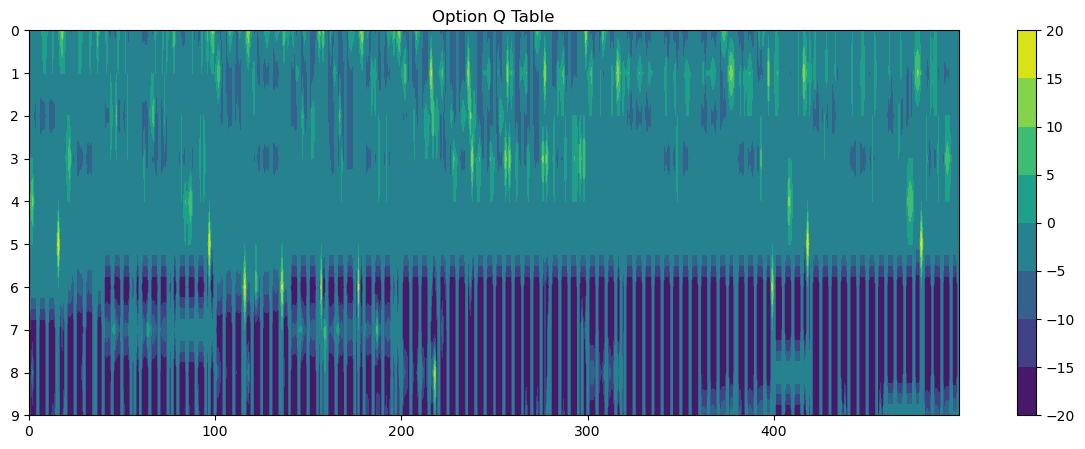

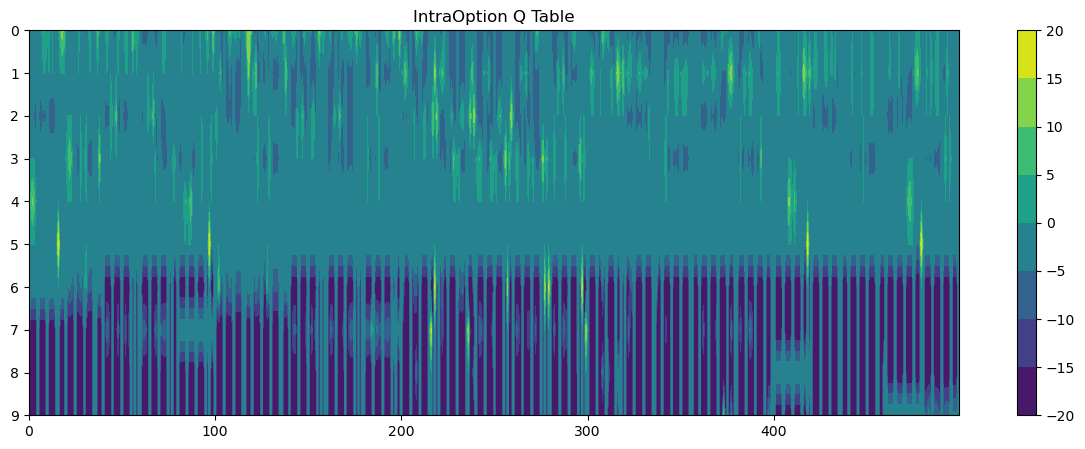

In [328]:
plot_heatmap(option_agent.q_omega_table.T ,"Option Q Table")
plot_heatmap(intra_option_agent.q_omega_table.T,"IntraOption Q Table")